In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel
import matplotlib.gridspec as gridspec
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats

import import_ipynb
import func_format
import func_analysis

def extractusableint(modality, intcat, foldername, presentationnumber):
    if modality == 'female':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Female']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Female']
    elif modality == 'male':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Male']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Male']
    elif modality == 'object':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Object']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Object']
    elif modality == 'food':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Food']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Food']
    elif modality == 'social':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Male']
        usableint = np.append(usableint, np.ravel(foldername)[np.ravel(intcat) == 'Female'])
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Male']
        usablepresentationnumber = np.append(usablepresentationnumber, np.ravel(presentationnumber)[np.ravel(intcat) == 'Female'])
    elif modality == 'nonsocial':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Object']
        usableint = np.append(usableint, np.ravel(foldername)[np.ravel(intcat) == 'Food'])
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Object']
        usablepresentationnumber = np.append(usablepresentationnumber, np.ravel(presentationnumber)[np.ravel(intcat) == 'Food'])
    elif modality == 'panresponsive':
        usableint = foldername
        usablepresentationnumber = presentationnumber
    else:
        usableint = foldername
        usablepresentationnumber = presentationnumber
    
    return(usableint, usablepresentationnumber)

def calculate_zscore(neuron, start, stop, basestart, basestop, binsize):
    spikes = func_analysis.extractSpikes(neuron, start, stop)
    fr = func_analysis.firingrate(spikes, binsize, start, stop, smooth=True, smoothkernel = 1)
    bins = np.arange(start, stop, binsize)
    
    baselinespikes = func_analysis.extractSpikes(neuron, basestart, basestop)
    baselinefr = func_analysis.firingrate(baselinespikes, binsize, basestart, basestop, smooth=True, smoothkernel = 1)
    meanbaseline = np.mean(baselinefr)
    stdbaseline = np.std(baselinefr)
    
    zscore_fr = (fr-meanbaseline)/stdbaseline
    zscorebaseline = (baselinefr-meanbaseline)/stdbaseline
    return(zscore_fr, bins, np.mean(zscorebaseline[-30:]))

def timewarp_interpolate(x, binnum):
    f_x = InterpolatedUnivariateSpline(np.arange(0, len(x)), x)
    newbins = np.linspace(0, len(x), binnum)
    x_interp = f_x(newbins)
    
    return(x_interp)

importing Jupyter notebook from func_format.ipynb
importing Jupyter notebook from func_analysis.ipynb


In [8]:
#### timewarp entire interaction period (baseline, interaction, postbaseline) to compare aftereffects

neuronselection = '/SpikeTimes/Neurons_BLA/'
ROCselection = '/ROC_BLA/'

savepath = 'F:/Figure3_day2/'
func_format.foldercheck(savepath)

zscoreresults = []
timewarpresults = np.zeros(899)
saveid = ['ratID', 'date', 'neuronname', 'neuroncat1', 'neuroncat2', 'intcat', 'inttype', 'intnumber', 'auroc']
intvalues = np.loadtxt('F:/InteractionPresentation.csv', delimiter = ',', dtype = str)

### return list with behavioral values from selected dates ONLY
date = ['13042019', '01102019', '27062020', '06072020']
intvalues = intvalues[np.isin(intvalues[:,1], date)]
### note above formatting: index0 = ratID, index1 = date, index2 = interaction#

### load neuron profile (multi, uni, inhibition, noresponse) from selected dates ONLY
neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)
neuronprofile = neuronprofile[np.isin(neuronprofile[:,1], date)]
### above formatting: index0 = ratID, index1 = date, index2 = neuronID, index3 = global type (multi, uni, inhibitory, n/a), index4 = modality response
rawvaluessave = ['Baseline Hz mean', 'Interaction Hz mean', 'Afterint Hz mean', 'Baseline Zscore mean', 'Interaction Zscore mean', 'Afterint Zscore mean']

for i, row in enumerate(neuronprofile):
    
    #### load neuron information based on responseprofile
    #### insert conditions for exclusion here (i.e. multimodal, unimodal, social, etc.)
    neuronpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/'+neuronselection+row[2]+'.npy'
    neuron = np.float_(np.ravel(np.load(neuronpath))/1000)
    
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    [foldername, inttype, intcat, presentationnumber, videosync_start, videosync_stop, framerate, usableframes, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    intdetails = intvalues[np.isin(intvalues[:,1], row[1])]
    
    [usableint, usablepresentationnumber] = extractusableint(row[4], intcat, foldername, presentationnumber)
    
    
    for j, row2 in enumerate(intdetails):
        
        if np.isin(row2[2], usableint) == True:# and np.ravel(usablepresentationnumber)[np.ravel(usableint) == row2[2]][0] == 4:
            
            syncpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/Sync/'+row2[2]+'_frameSync.csv'
            sync = np.loadtxt(syncpath, delimiter = ',', dtype = str)
            
            presentation = np.float32(sync[np.int(row2[4])])
            presentationstart = np.float32(sync[np.int(row2[3])])
            removal = np.float32(sync[np.int(row2[-2])])
            
            [zscore_fr, bins, baselinetest] = calculate_zscore(neuron, presentation-300, removal+300, 
                                         presentationstart-300, presentationstart-10, 1)
            zscoreresults.append([zscore_fr])
            
            #### timewarps data
            removalbin = np.argmin(np.abs(bins - removal))
            
            beforeinteractionfr = zscore_fr[:300]
            interactionfr = zscore_fr[300:removalbin]
            postinteractionfr = zscore_fr[removalbin:removalbin+299]
            
            interactionfr = timewarp_interpolate(interactionfr, 300)
            
            timewarp_fr = np.hstack((beforeinteractionfr, interactionfr, postinteractionfr))
            timewarpresults = np.vstack((timewarpresults, timewarp_fr))
            
            idinfo = [row[0], row[1], row[2], row[3], row[4], intcat[j], inttype[j], row2[2], 'nan']
            
            saveid = np.vstack((saveid, idinfo))
            
timewarpresults = timewarpresults[1:]

<ipython-input-1-b11a02220eb5>:55: RuntimeWarning: divide by zero encountered in true_divide
  zscore_fr = (fr-meanbaseline)/stdbaseline
<ipython-input-1-b11a02220eb5>:55: RuntimeWarning: invalid value encountered in true_divide
  zscore_fr = (fr-meanbaseline)/stdbaseline
<ipython-input-1-b11a02220eb5>:56: RuntimeWarning: invalid value encountered in true_divide
  zscorebaseline = (baselinefr-meanbaseline)/stdbaseline


In [9]:
beginningall = np.zeros(240)
endingall = np.zeros(240)

for x, row in enumerate(zscoreresults):
    
    if saveid[x+1][3] == 'unimodal' or saveid[x+1][3] == 'multimodal':
    
        beginningfr = row[0][180:420]
        endingfr = row[0][-420:-180]
    
        beginningall = np.vstack((beginningall, beginningfr))
        endingall = np.vstack((endingall, endingfr))
    
beginningall = beginningall[1:]
endingall = endingall[1:]
    

In [10]:
### separated by panresponsive versus unimodal

beginningallpan = np.zeros(240)
endingallpan = np.zeros(240)

beginningalluni = np.zeros(240)
endingalluni = np.zeros(240)

beginningallnon = np.zeros(240)
endingallnon = np.zeros(240)

for x, row in enumerate(zscoreresults):
    
    if saveid[x+1][3] == 'unimodal':
    
        beginningfr = row[0][180:420]
        endingfr = row[0][-420:-180]
    
        beginningalluni = np.vstack((beginningalluni, beginningfr))
        endingalluni = np.vstack((endingalluni, endingfr))
        
    if saveid[x+1][4] == 'panresponsive':
        
        beginningfr = row[0][180:420]
        endingfr = row[0][-420:-180]
        
        beginningallpan = np.vstack((beginningallpan, beginningfr))
        endingallpan = np.vstack((endingallpan, endingfr))
        
    if saveid[x+1][3] == 'NoResponses':
        
        beginningfr = row[0][180:420]
        endingfr = row[0][-420:-180]
        
        beginningallnon = np.vstack((beginningallnon, beginningfr))
        endingallnon = np.vstack((endingallnon, endingfr))
    
beginningalluni = beginningalluni[1:]
endingalluni = endingalluni[1:]

beginningallpan = beginningallpan[1:]
endingallpan = endingallpan[1:]

beginningallnon = beginningallnon[1:]
endingallnon = endingallnon[1:]
  

In [6]:
np.savetxt('F:/Figure3_New/aftereffect_uni_day2.csv', endingalluni, delimiter =',')
np.savetxt('F:/Figure3_New/aftereffect_pan_day2.csv', endingallpan, delimiter = ',')
np.savetxt('F:/Figure3_New/aftereffect_non_day2.csv', endingallnon, delimiter = ',')

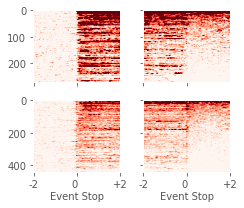

In [14]:
### sorted by strength of aftereffect

sortorderuni = np.argsort(np.mean(endingalluni[:,120:], axis = 1))
endingallsorteduni = np.take_along_axis(endingalluni, sortorderuni.reshape(-1,1), axis = 0)
beginningallsorteduni = np.take_along_axis(beginningalluni, sortorderuni.reshape(-1,1), axis = 0)

sortorderpan = np.argsort(np.mean(endingallpan[:,120:], axis = 1))
endingallsortedpan = np.take_along_axis(endingallpan, sortorderpan.reshape(-1,1), axis = 0)
beginningallsortedpan = np.take_along_axis(beginningallpan, sortorderpan.reshape(-1,1), axis = 0)

fig, ax = plt.subplots(2,2, figsize = (3.5,3), sharey = 'row', sharex= True)

ax[0,0].imshow(np.flip(beginningallsorteduni, axis = 0), aspect = 'auto', cmap = 'Reds', vmin = 0, vmax = 5)
ax[0,1].imshow(np.flip(endingallsorteduni, axis = 0), aspect = 'auto', cmap = 'Reds', vmin = 0, vmax = 5)

ax[1,0].imshow(np.flip(beginningallsortedpan, axis = 0), aspect = 'auto', cmap = 'Reds', vmin = 0, vmax = 5)
a = ax[1,1].imshow(np.flip(endingallsortedpan, axis = 0), aspect = 'auto', cmap = 'Reds', vmin = 0, vmax = 5)

ax[0,0].grid(False)
ax[0,1].grid(False)
ax[1,0].grid(False)
ax[1,1].grid(False)

#plt.colorbar(test)



ax[1,0].set_xticks((0,120,240))
ax[1,1].set_xticks((0,120,240))

ax[1,0].set_xticklabels(('-2', '0 \nEvent Start', '+2'))
ax[1,1].set_xticklabels(('-2', '0 \nEvent Stop', '+2'))
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'

#plt.savefig('F:/Figure3_New/population.svg', format = 'svg', dpi = 500, transparent = True)

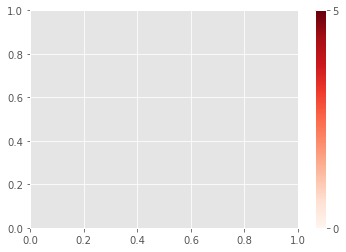

In [16]:
#fig, ax = plt.subplots(1)

plt.colorbar(a, ticks = (0,5))
plt.savefig('F:/colorbar.svg', format = 'svg', dpi = 500, transparent = True)

In [8]:
unimodalpercentage = []
for x, window in enumerate(np.arange(0, len(endingalluni[0])-9, 10)):
    aftereffectresponse = np.mean(endingalluni[:, window:window+10], axis = 1)
    percentage = np.count_nonzero(aftereffectresponse > 1) / len(aftereffectresponse)
    unimodalpercentage = np.append(unimodalpercentage, percentage)
    
panpercentage = []
for x, window in enumerate(np.arange(0, len(endingallpan[0])-9, 10)):
    aftereffectresponse = np.mean(endingallpan[:, window:window+10], axis = 1)
    percentage = np.count_nonzero(aftereffectresponse > 1) / len(aftereffectresponse)
    panpercentage = np.append(panpercentage, percentage)
    
noresponsepercentage = []
for x, window in enumerate(np.arange(0, len(endingallpan[0])-9, 10)):
    aftereffectresponse = np.mean(endingallnon[:,window:window+10], axis = 1)
    percentage = np.count_nonzero(aftereffectresponse > 1) / len(aftereffectresponse)
    
    noresponsepercentage = np.append(noresponsepercentage, percentage)   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


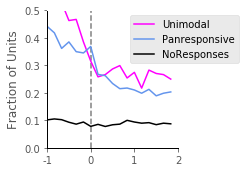

In [9]:
fig, ax = plt.subplots(1, figsize = (4.25,2.5))

ax.plot(unimodalpercentage, color = 'magenta')
ax.plot(panpercentage, color = 'cornflowerblue')
ax.plot(noresponsepercentage, color = 'black')

ax.grid(False)
ax.set_facecolor('white')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')

ax.legend(('Unimodal', 'Panresponsive', 'NoResponses'), bbox_to_anchor = (1.5,1))

ax.set_ylim(0,0.5)
ax.set_xticks((0,6,12,18,24))
ax.set_xticklabels((-2,-1,0,1,2))
ax.set_ylabel('Fraction of Units')
ax.set_xlim(6,24)

ax.vlines(12, ymin = 0, ymax = 0.5,linestyle = '--', alpha = 0.5)
plt.tight_layout()
#plt.savefig('F:/Figure3_New/aftereffectduration.svg', format = 'svg', dpi = 500, transparent = True)

In [11]:
uniday1 = np.loadtxt('F:/Figure3_New/aftereffect_uni.csv', delimiter =',', dtype = float)
panday1 = np.loadtxt('F:/Figure3_New/aftereffect_pan.csv', delimiter = ',', dtype = float)
nonday1 = np.loadtxt('F:/Figure3_New/aftereffect_non.csv', delimiter = ',', dtype = float)

uniday2 = np.loadtxt('F:/Figure3_New/aftereffect_uni_day2.csv', delimiter = ',', dtype = float)
panday2 = np.loadtxt('F:/Figure3_New/aftereffect_pan_day2.csv', delimiter = ',', dtype = float)
nonday2 = np.loadtxt('F:/Figure3_New/aftereffect_non_day2.csv', delimiter = ',', dtype = float)

In [17]:
unimodalpercentage1 = []
for x, window in enumerate(np.arange(0, len(uniday1[0])-9, 10)):
    aftereffectresponse = np.mean(uniday1[:, window:window+10], axis = 1)
    percentage = np.count_nonzero(aftereffectresponse > 1) / len(aftereffectresponse)
    unimodalpercentage1 = np.append(unimodalpercentage1, percentage)
    
panpercentage1 = []
for x, window in enumerate(np.arange(0, len(panday1[0])-9, 10)):
    aftereffectresponse = np.mean(panday1[:, window:window+10], axis = 1)
    percentage = np.count_nonzero(aftereffectresponse > 1) / len(aftereffectresponse)
    panpercentage1 = np.append(panpercentage1, percentage)
    
noresponsepercentage1 = []
for x, window in enumerate(np.arange(0, len(nonday1[0])-9, 10)):
    aftereffectresponse = np.mean(nonday1[:,window:window+10], axis = 1)
    percentage = np.count_nonzero(aftereffectresponse > 1) / len(aftereffectresponse)
    
    noresponsepercentage1 = np.append(noresponsepercentage1, percentage)   
    
unimodalpercentage2 = []
for x, window in enumerate(np.arange(0, len(uniday2[0])-9, 10)):
    aftereffectresponse = np.mean(uniday2[:, window:window+10], axis = 1)
    percentage = np.count_nonzero(aftereffectresponse > 1) / len(aftereffectresponse)
    unimodalpercentage2 = np.append(unimodalpercentage2, percentage)
    
panpercentage2 = []
for x, window in enumerate(np.arange(0, len(panday2[0])-9, 10)):
    aftereffectresponse = np.mean(panday2[:, window:window+10], axis = 1)
    percentage = np.count_nonzero(aftereffectresponse > 1) / len(aftereffectresponse)
    panpercentage2 = np.append(panpercentage2, percentage)
    
noresponsepercentage2 = []
for x, window in enumerate(np.arange(0, len(nonday2[0])-9, 10)):
    aftereffectresponse = np.mean(nonday2[:,window:window+10], axis = 1)
    percentage = np.count_nonzero(aftereffectresponse > 1) / len(aftereffectresponse)
    
    noresponsepercentage2 = np.append(noresponsepercentage2, percentage)  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


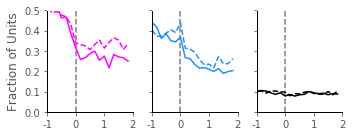

In [29]:
fig, ax = plt.subplots(1,3, figsize = (5,2), sharex = True, sharey = True)

ax[0].plot(unimodalpercentage1, color = 'magenta', linestyle = '--')
ax[1].plot(panpercentage1, color = 'dodgerblue', linestyle = '--')
ax[2].plot(noresponsepercentage1, color = 'black', linestyle = '--')

ax[0].plot(unimodalpercentage2, color = 'magenta')
ax[1].plot(panpercentage2, color = 'dodgerblue')
ax[2].plot(noresponsepercentage2, color = 'black')

ax[0].grid(False)
ax[0].set_facecolor('white')
ax[0].spines['left'].set_color('k')
ax[0].spines['bottom'].set_color('k')
ax[1].grid(False)
ax[1].set_facecolor('white')
ax[1].spines['left'].set_color('k')
ax[1].spines['bottom'].set_color('k')
ax[2].grid(False)
ax[2].set_facecolor('white')
ax[2].spines['left'].set_color('k')
ax[2].spines['bottom'].set_color('k')

#ax[0].legend(('Unimodal', 'Panresponsive', 'NoResponses'), bbox_to_anchor = (1.5,1))

ax[0].set_ylim(0,0.5)
ax[0].set_xticks((0,6,12,18,24))
ax[0].set_xticklabels((-2,-1,0,1,2))
ax[0].set_ylabel('Fraction of Units')
ax[0].set_xlim(6,24)

ax[0].vlines(12, ymin = 0, ymax = 0.5,linestyle = '--', alpha = 0.5)
ax[1].vlines(12, ymin = 0, ymax = 0.5, linestyle = '--', alpha = 0.5)
ax[2].vlines(12, ymin = 0, ymax = 0.5, linestyle = '--', alpha = 0.5)

plt.tight_layout()
plt.savefig('F:/Figure3_New/aftereffectduration_day1day2.svg', format = 'svg', dpi = 500, transparent = True)

In [41]:
print(np.mean(unimodalpercentage1[12:]))
print(np.mean(panpercentage1[12:]))
print(np.mean(noresponsepercentage1[12:]))

0.33393501805054154
0.2755831452219714
0.09166403037013604


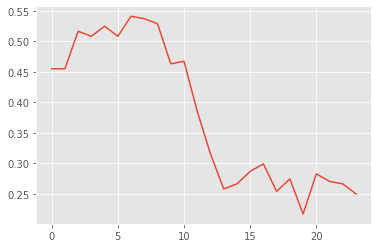

In [35]:
plt.plot(unimodalpercentage)